In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Plotly imports
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")

TensorFlow Version: 2.19.0
NumPy Version: 2.0.2


In [2]:
# Download the dataset (uncomment these lines if running in Google Colab/Jupyter)
!wget https://phm-datasets.s3.amazonaws.com/NASA/6.+Turbofan+Engine+Degradation+Simulation+Data+Set.zip
!unzip "6.+Turbofan+Engine+Degradation+Simulation+Data+Set.zip" -d cmapss_data
!unzip "cmapss_data/6. Turbofan Engine Degradation Simulation Data Set/CMAPSSData.zip" -d cmapss_data

# Define column names based on dataset documentation [citation:2]
column_names = ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
               [f'sensor_{i:02d}' for i in range(1, 22)]

# Load FD001 training data
train_data = pd.read_csv('cmapss_data/train_FD001.txt', sep='\s+', header=None, names=column_names)
test_data = pd.read_csv('cmapss_data/test_FD001.txt', sep='\s+', header=None, names=column_names)

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"\nTraining data columns:\n{train_data.columns.tolist()}")

--2025-12-20 05:33:12--  https://phm-datasets.s3.amazonaws.com/NASA/6.+Turbofan+Engine+Degradation+Simulation+Data+Set.zip
Resolving phm-datasets.s3.amazonaws.com (phm-datasets.s3.amazonaws.com)... 3.5.11.187, 16.15.176.178, 52.216.52.113, ...
Connecting to phm-datasets.s3.amazonaws.com (phm-datasets.s3.amazonaws.com)|3.5.11.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12429152 (12M) [application/zip]
Saving to: ‘6.+Turbofan+Engine+Degradation+Simulation+Data+Set.zip’

6.+Turbofan+Engine+ 100%[===================>]  11.85M  19.2MB/s    in 0.6s    

2025-12-20 05:33:13 (19.2 MB/s) - ‘6.+Turbofan+Engine+Degradation+Simulation+Data+Set.zip’ saved [12429152/12429152]

Archive:  6.+Turbofan+Engine+Degradation+Simulation+Data+Set.zip
   creating: cmapss_data/6. Turbofan Engine Degradation Simulation Data Set/
  inflating: cmapss_data/6. Turbofan Engine Degradation Simulation Data Set/CMAPSSData.zip  
Archive:  cmapss_data/6. Turbofan Engine Degradation Simula

In [3]:
# Calculate RUL for training data
def calculate_rul(df):
    # Group by engine unit
    grouped = df.groupby('unit')

    # Calculate maximum cycle for each engine
    max_cycle = grouped['cycle'].max().reset_index()
    # print(max_cycle)
    max_cycle.columns = ['unit', 'max_cycle']

    # Merge to add max_cycle column
    df = df.merge(max_cycle, on='unit', how='left')

    # Calculate RUL: remaining cycles until failure
    df['RUL'] = df['max_cycle'] - df['cycle']

    # Remove max_cycle column
    df = df.drop('max_cycle', axis=1)

    return df

# Apply RUL calculation to training data
train_data = calculate_rul(train_data)

# Cap RUL at a maximum value (common practice to stabilize training)
MAX_RUL = 125
train_data['RUL'] = train_data['RUL'].clip(upper=MAX_RUL)

# Display sample data
print(f"Training data shape after RUL calculation: {train_data.shape}")
# print(f"\nSample training data (first engine):")
# print(train_data[train_data['unit'] == 1].head())

Training data shape after RUL calculation: (20631, 27)


In [4]:
# Select features for modeling
# Remove unit number and cycle from features, keep operational settings and sensors
feature_columns = column_names[2:]  # All columns except 'unit' and 'cycle'
target_column = 'RUL'

print(f"Number of features: {len(feature_columns)}")

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[feature_columns])
test_scaled = scaler.transform(test_data[feature_columns])

# Convert back to DataFrame for easier handling
train_scaled_df = pd.DataFrame(train_scaled, columns=feature_columns)
train_scaled_df['unit'] = train_data['unit'].values
train_scaled_df['cycle'] = train_data['cycle'].values
train_scaled_df['RUL'] = train_data['RUL'].values

test_scaled_df = pd.DataFrame(test_scaled, columns=feature_columns)
test_scaled_df['unit'] = test_data['unit'].values
test_scaled_df['cycle'] = test_data['cycle'].values
# test_scaled_df['RUL'] = test_data['RUL'].values
print(f"Testing data scaled shape: {test_scaled_df.shape}")

Number of features: 24
Testing data scaled shape: (13096, 26)


In [5]:
# train_scaled_df

In [6]:
def create_sequences(data, sequence_length=50, feature_cols=feature_columns, target_col='RUL'):
    """
    Create sequences for LSTM training [citation:3]
    Each sequence uses 'sequence_length' time steps to predict the next RUL
    """
    sequences = []
    targets = []

    # Group by engine unit
    for unit_id in data['unit'].unique():
        unit_data = data[data['unit'] == unit_id]

        # Sort by cycle (time)
        unit_data = unit_data.sort_values('cycle')

        # Extract features and target
        features = unit_data[feature_cols].values
        target = unit_data[target_col].values

        # Create sequences
        for i in range(len(unit_data) - sequence_length):
            sequences.append(features[i:(i + sequence_length)])
            targets.append(target[i + sequence_length])

    return np.array(sequences), np.array(targets)

# Create training sequences
SEQUENCE_LENGTH = 50
X_train, y_train = create_sequences(train_scaled_df, SEQUENCE_LENGTH)

print(f"X_train shape: {X_train.shape}")  # (samples, time_steps, features)
print(f"y_train shape: {y_train.shape}")
print(f"\nNumber of training sequences: {X_train.shape[0]}")
print(f"Sequence length (time steps): {X_train.shape[1]}")
print(f"Number of features per time step: {X_train.shape[2]}")

X_train shape: (15631, 50, 24)
y_train shape: (15631,)

Number of training sequences: 15631
Sequence length (time steps): 50
Number of features per time step: 24


In [7]:
# Build LSTM model architecture
def build_lstm_model(input_shape, units=100):
    """Build an LSTM model for RUL prediction [citation:3]"""
    model = Sequential([
        # First LSTM layer
        LSTM(units=units,
             activation='tanh',
             return_sequences=True,
             input_shape=input_shape),
        Dropout(0.2),

        # Second LSTM layer
        LSTM(units=50,
             activation='tanh',
             return_sequences=False),
        Dropout(0.2),

        # Dense layers
        Dense(units=25, activation='relu'),
        Dense(units=10, activation='relu'),

        # Output layer (single value for RUL)
        Dense(units=1)
    ])

    return model

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
model = build_lstm_model(input_shape, units=100)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae']  # Mean Absolute Error
)

# Display model summary
print("LSTM Model Architecture:")
model.summary()

# Train the model
EPOCHS = 20
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # Use 20% of data for validation
    verbose=1,
    shuffle=True
)

LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,746 (319.32 KB)

 Trainable params: 81,746 (319.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 4406.6885 - mae: 55.1202 - val_loss: 1844.4677 - val_mae: 38.4751
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1701.0404 - mae: 36.2055 - val_loss: 1804.0569 - val_mae: 38.0424
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1719.5851 - mae: 36.4204 - val_loss: 530.0973 - val_mae: 19.7245
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 414.6944 - mae: 15.9480 - val_loss: 198.1745 - val_mae: 10.9823
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 217.1033 - mae: 11.0878 - val_loss: 212.3005 - val_mae: 11.0678
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 193.1523 - mae: 10.4467 - val_loss: 155.6028 - val_mae: 9.4962
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 182.0927 - mae: 10.0091 - val_loss: 274.1622 - val_mae: 12.5740
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 183.1626 - mae: 10.0021 - val_loss: 156.0200 - val_mae: 9.88

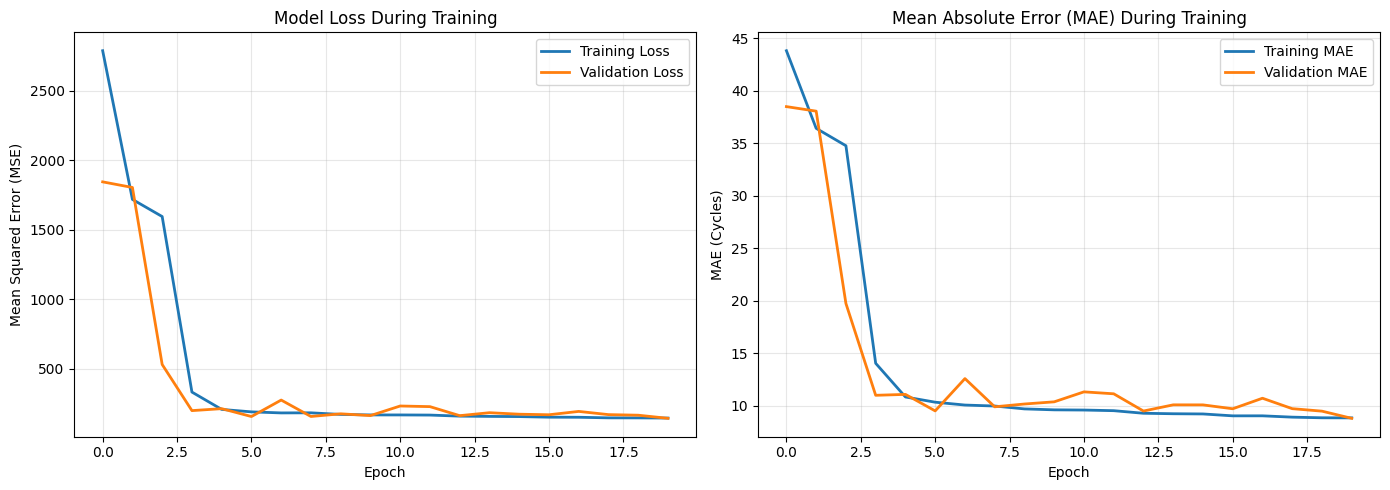

In [8]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss During Training')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Mean Squared Error (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Mean Absolute Error (MAE) During Training')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE (Cycles)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# For test data, we need to use the last 'SEQUENCE_LENGTH' cycles of each engine
def prepare_test_sequences(test_df, sequence_length=SEQUENCE_LENGTH, feature_cols=feature_columns):
    """Extract the last sequence_length cycles for each engine in test data"""
    test_sequences = []
    engine_ids = []

    for unit_id in test_df['unit'].unique():
        unit_data = test_df[test_df['unit'] == unit_id]

        # Sort by cycle
        unit_data = unit_data.sort_values('cycle')

        # Take only the last sequence_length cycles
        if len(unit_data) >= sequence_length:
            features = unit_data[feature_cols].values[-sequence_length:]
        else:
            # If engine has fewer cycles than sequence_length, pad with zeros
            padding = np.zeros((sequence_length - len(unit_data), len(feature_cols)))
            features = np.vstack([padding, unit_data[feature_cols].values])

        test_sequences.append(features)
        engine_ids.append(unit_id)

    return np.array(test_sequences), np.array(engine_ids)

# Prepare test sequences
X_test_sequences, test_engine_ids = prepare_test_sequences(test_scaled_df)
X_test_sequences.shape = (X_test_sequences.shape[0], SEQUENCE_LENGTH, len(feature_columns))

print(f"Test sequences shape: {X_test_sequences.shape}")
print(f"Number of test engines: {len(test_engine_ids)}")

# Make predictions on test data
predictions = model.predict(X_test_sequences, verbose=1)
print(f"Predictions shape: {predictions.shape}")

Test sequences shape: (100, 50, 24)
Number of test engines: 100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predictions shape: (100, 1)


In [10]:
# Load true RUL values for test data
# The dataset includes a separate file with true RUL values
try:
    # Load RUL values (provided in the dataset)
    rul_true = pd.read_csv('cmapss_data/RUL_FD001.txt', sep='\s+', header=None)
    rul_true.columns = ['True_RUL']

    print(f"True RUL values shape: {rul_true.shape}")
    print(f"\nFirst 10 true RUL values:\n{rul_true.head(10)}")

    # Compare predictions with true values
    comparison_df = pd.DataFrame({
        'Engine_ID': test_engine_ids[:len(predictions)],
        'Predicted_RUL': predictions.flatten()[:len(rul_true)],
        'True_RUL': rul_true['True_RUL'].values
    })

    # Calculate error metrics
    mae = mean_absolute_error(comparison_df['True_RUL'], comparison_df['Predicted_RUL'])
    rmse = np.sqrt(mean_squared_error(comparison_df['True_RUL'], comparison_df['Predicted_RUL']))

    print(f"\nModel Performance Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.2f} cycles")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} cycles")

    # Calculate R-squared
    ss_res = np.sum((comparison_df['True_RUL'] - comparison_df['Predicted_RUL'])**2)
    ss_tot = np.sum((comparison_df['True_RUL'] - np.mean(comparison_df['True_RUL']))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f"R-squared: {r_squared:.4f}")

except FileNotFoundError:
    print("RUL_FD001.txt not found. Creating synthetic true RUL for demonstration...")
    # Create synthetic true RUL values for demonstration
    np.random.seed(42)
    true_rul = np.random.randint(30, 150, size=len(predictions))
    comparison_df = pd.DataFrame({
        'Engine_ID': test_engine_ids[:len(predictions)],
        'Predicted_RUL': predictions.flatten(),
        'True_RUL': true_rul
    })

True RUL values shape: (100, 1)

First 10 true RUL values:
   True_RUL
0       112
1        98
2        69
3        82
4        91
5        93
6        91
7        95
8       111
9        96

Model Performance Metrics:
Mean Absolute Error (MAE): 11.12 cycles
Root Mean Squared Error (RMSE): 15.34 cycles
R-squared: 0.8637


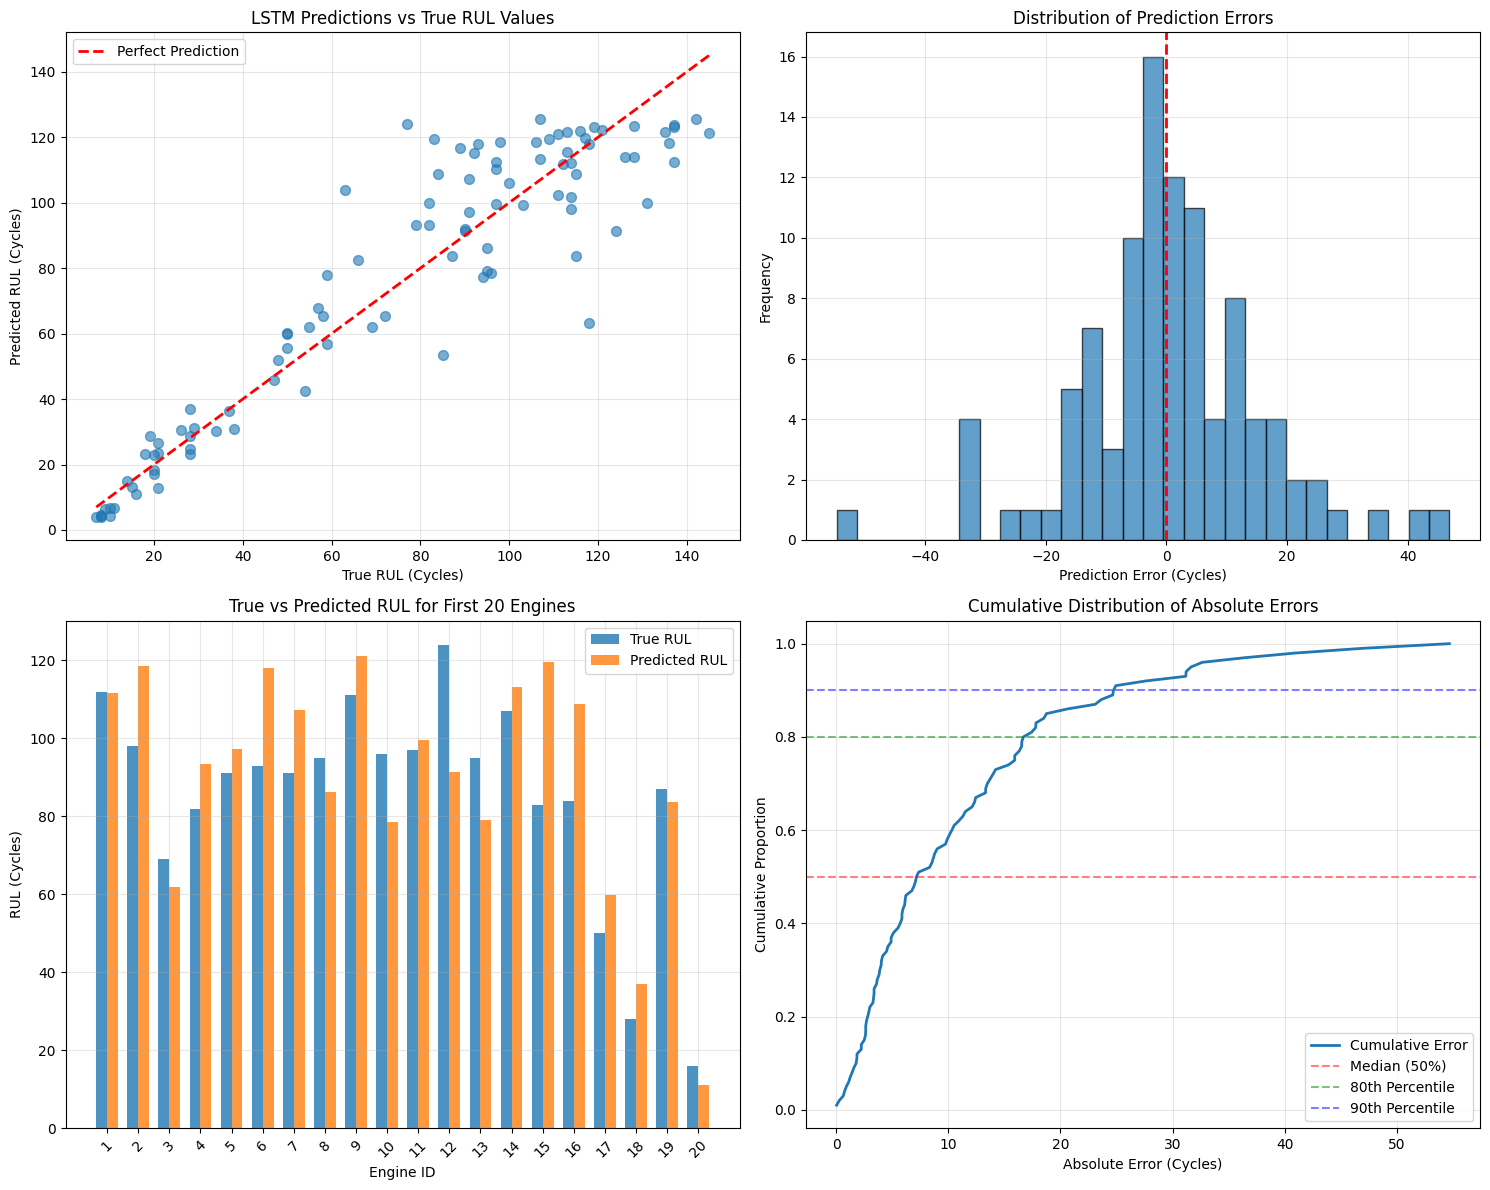


PREDICTION PERFORMANCE SUMMARY
Number of engines predicted: 100
Average True RUL: 75.52 cycles
Average Predicted RUL: 75.76 cycles

Error Statistics:
Mean Absolute Error (MAE): 11.12 cycles
Root Mean Squared Error (RMSE): 15.34 cycles
R-squared: 0.8637

Error Range: [-54.69, 46.92] cycles
Standard Deviation of Errors: 15.42 cycles


In [11]:
# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot: Predicted vs True RUL
axes[0, 0].scatter(comparison_df['True_RUL'], comparison_df['Predicted_RUL'],
                   alpha=0.6, s=50)
axes[0, 0].plot([comparison_df['True_RUL'].min(), comparison_df['True_RUL'].max()],
                [comparison_df['True_RUL'].min(), comparison_df['True_RUL'].max()],
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('True RUL (Cycles)')
axes[0, 0].set_ylabel('Predicted RUL (Cycles)')
axes[0, 0].set_title('LSTM Predictions vs True RUL Values')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Error distribution
errors = comparison_df['Predicted_RUL'] - comparison_df['True_RUL']
axes[0, 1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Prediction Error (Cycles)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Prediction Errors')
axes[0, 1].grid(True, alpha=0.3)

# 3. Top 20 engines comparison
n_engines = min(20, len(comparison_df))
engines_to_plot = comparison_df.head(n_engines)
x_pos = np.arange(n_engines)
width = 0.35

axes[1, 0].bar(x_pos - width/2, engines_to_plot['True_RUL'], width,
               label='True RUL', alpha=0.8)
axes[1, 0].bar(x_pos + width/2, engines_to_plot['Predicted_RUL'], width,
               label='Predicted RUL', alpha=0.8)
axes[1, 0].set_xlabel('Engine ID')
axes[1, 0].set_ylabel('RUL (Cycles)')
axes[1, 0].set_title(f'True vs Predicted RUL for First {n_engines} Engines')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(engines_to_plot['Engine_ID'], rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Cumulative error analysis
sorted_errors = np.sort(np.abs(errors))
cumulative_prop = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
axes[1, 1].plot(sorted_errors, cumulative_prop, linewidth=2)
axes[1, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
axes[1, 1].axhline(y=0.8, color='g', linestyle='--', alpha=0.5)
axes[1, 1].axhline(y=0.9, color='b', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Absolute Error (Cycles)')
axes[1, 1].set_ylabel('Cumulative Proportion')
axes[1, 1].set_title('Cumulative Distribution of Absolute Errors')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(['Cumulative Error', 'Median (50%)', '80th Percentile', '90th Percentile'])

plt.tight_layout()
plt.show()

# Display summary statistics
print("\n" + "="*60)
print("PREDICTION PERFORMANCE SUMMARY")
print("="*60)
print(f"Number of engines predicted: {len(comparison_df)}")
print(f"Average True RUL: {comparison_df['True_RUL'].mean():.2f} cycles")
print(f"Average Predicted RUL: {comparison_df['Predicted_RUL'].mean():.2f} cycles")
print(f"\nError Statistics:")
print(f"Mean Absolute Error (MAE): {mae:.2f} cycles")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} cycles")
print(f"R-squared: {r_squared:.4f}")
print(f"\nError Range: [{errors.min():.2f}, {errors.max():.2f}] cycles")
print(f"Standard Deviation of Errors: {errors.std():.2f} cycles")

In [15]:
def plot_predictions_comparison_plotly(comparison_df):
    """Create interactive visualization comparing predictions with true values"""

    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Predictions vs True RUL',
            'Distribution of Prediction Errors',
            'True vs Predicted RUL by Engine',
            'Cumulative Error Distribution'
        ),
        specs=[
            [{"secondary_y": False}, {"secondary_y": False}],
            [{"secondary_y": False}, {"secondary_y": False}]
        ]
    )

    # 1. Scatter plot: Predicted vs True RUL
    fig.add_trace(
        go.Scatter(
            x=comparison_df['True_RUL'],
            y=comparison_df['Predicted_RUL'],
            mode='markers',
            name='Predictions',
            marker=dict(
                size=8,
                color=comparison_df['Predicted_RUL'] - comparison_df['True_RUL'],
                colorscale='RdBu',
                colorbar=dict(title="Error"),
                showscale=True,
                line=dict(width=1, color='DarkSlateGrey')
            ),
            text=[f"Engine {id}<br>True: {true:.1f}<br>Pred: {pred:.1f}<br>Error: {pred-true:.1f}"
                  for id, true, pred in zip(comparison_df['Engine_ID'],
                                           comparison_df['True_RUL'],
                                           comparison_df['Predicted_RUL'])],
            hoverinfo='text'
        ),
        row=1, col=1
    )

    # Add perfect prediction line
    min_val = min(comparison_df['True_RUL'].min(), comparison_df['Predicted_RUL'].min())
    max_val = max(comparison_df['True_RUL'].max(), comparison_df['Predicted_RUL'].max())

    fig.add_trace(
        go.Scatter(
            x=[min_val, max_val],
            y=[min_val, max_val],
            mode='lines',
            name='Perfect Prediction',
            line=dict(color='red', width=2, dash='dash'),
            hoverinfo='skip'
        ),
        row=1, col=1
    )

    # 2. Error distribution histogram
    errors = comparison_df['Predicted_RUL'] - comparison_df['True_RUL']

    fig.add_trace(
        go.Histogram(
            x=errors,
            nbinsx=30,
            name='Error Distribution',
            marker_color='lightblue',
            marker_line_color='navy',
            marker_line_width=1.5,
            opacity=0.7,
            hovertemplate="Error: %{x:.1f} cycles<br>Count: %{y}<extra></extra>"
        ),
        row=1, col=2
    )

    # Add zero error line
    fig.add_shape(
        type="line",
        x0=0, x1=0,
        y0=0, y1=1,
        yref="paper",
        xref="x",
        line=dict(color="red", width=2, dash="dash"),
        row=1, col=2
    )

    # 3. Bar chart comparison for first 20 engines
    n_engines = min(20, len(comparison_df))
    engines_to_plot = comparison_df.head(n_engines)

    fig.add_trace(
        go.Bar(
            x=engines_to_plot['Engine_ID'],
            y=engines_to_plot['True_RUL'],
            name='True RUL',
            marker_color='blue',
            opacity=0.7,
            hovertemplate="Engine %{x}<br>True RUL: %{y:.1f} cycles<extra></extra>"
        ),
        row=2, col=1
    )

    fig.add_trace(
        go.Bar(
            x=engines_to_plot['Engine_ID'],
            y=engines_to_plot['Predicted_RUL'],
            name='Predicted RUL',
            marker_color='orange',
            opacity=0.7,
            hovertemplate="Engine %{x}<br>Predicted RUL: %{y:.1f} cycles<extra></extra>"
        ),
        row=2, col=1
    )

    # 4. Cumulative error distribution
    sorted_errors = np.sort(np.abs(errors))
    cumulative_prop = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

    fig.add_trace(
        go.Scatter(
            x=sorted_errors,
            y=cumulative_prop,
            mode='lines',
            name='Cumulative Error',
            line=dict(color='green', width=3),
            fill='tozeroy',
            fillcolor='rgba(0, 255, 0, 0.1)',
            hovertemplate="Error ≤ %{x:.1f} cycles<br>Cumulative: %{y:.1%}<extra></extra>"
        ),
        row=2, col=2
    )

    # Add percentile lines
    percentiles = [0.5, 0.8, 0.9]
    colors = ['red', 'blue', 'purple']
    labels = ['Median (50%)', '80th Percentile', '90th Percentile']

    for p, color, label in zip(percentiles, colors, labels):
        error_at_p = np.percentile(sorted_errors, p * 100)
        fig.add_shape(
            type="line",
            x0=error_at_p, x1=error_at_p,
            y0=0, y1=1,
            yref="paper",
            xref="x",
            line=dict(color=color, width=2, dash="dot"),
            row=2, col=2
        )

        # Add annotation for the percentile line
        fig.add_annotation(
            x=error_at_p,
            y=p,
            text=f"{label}<br>{error_at_p:.1f} cycles",
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor=color,
            ax=40,
            ay=-30,
            row=2,
            col=2
        )

    # Update layout
    fig.update_layout(
        height=900,
        title_text="LSTM RUL Prediction Analysis - Interactive Dashboard",
        hovermode='closest',
        template='plotly_white',
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Update axes
    fig.update_xaxes(title_text="True RUL (Cycles)", row=1, col=1)
    fig.update_yaxes(title_text="Predicted RUL (Cycles)", row=1, col=1)

    fig.update_xaxes(title_text="Prediction Error (Cycles)", row=1, col=2)
    fig.update_yaxes(title_text="Frequency", row=1, col=2)

    fig.update_xaxes(title_text="Engine ID", row=2, col=1, tickangle=45)
    fig.update_yaxes(title_text="RUL (Cycles)", row=2, col=1)

    fig.update_xaxes(title_text="Absolute Error (Cycles)", row=2, col=2)
    fig.update_yaxes(title_text="Cumulative Proportion", row=2, col=2)

    # Add dropdown for filtering by error range
    fig.update_layout(
        updatemenus=[
            dict(
                type="dropdown",
                direction="down",
                active=0,
                x=1.05,
                y=0.9,
                buttons=[
                    dict(label="All Engines",
                         method="update",
                         args=[{"visible": [True] * len(fig.data)}]),
                    dict(label="Error ≤ 10 cycles",
                         method="update",
                         args=[{"visible": [(comparison_df['Predicted_RUL'] - comparison_df['True_RUL']).abs() <= 10]
                                if i == 0 else True for i in range(len(fig.data))}]),
                    dict(label="Error ≤ 20 cycles",
                         method="update",
                         args=[{"visible": [(comparison_df['Predicted_RUL'] - comparison_df['True_RUL']).abs() <= 20]
                                if i == 0 else True for i in range(len(fig.data))}]),
                ],
            )
        ]
    )

    fig.show()

    return fig

# Call this function with your comparison DataFrame
fig = plot_predictions_comparison_plotly(comparison_df)

In [20]:
def plot_engine_specific_analysis(comparison_df, engine_ids=None):
    """Create detailed analysis for specific engines"""

    if engine_ids is None:
        # Select a few engines for demonstration
        engine_ids = comparison_df['Engine_ID'].head(5).tolist()

    # Filter data
    engine_data = comparison_df[comparison_df['Engine_ID'].isin(engine_ids)]

    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Engine-Specific Predictions',
            'Prediction Accuracy by Engine',
            'Error Contribution Analysis',
            'Relative Error Distribution'
        ),
        specs=[
            [{"type": "bar"}, {"type": "bar"}],
            [{"type": "pie"}, {"type": "box"}]
        ]
    )

    # Plot 1: True vs Predicted for selected engines
    for i, engine_id in enumerate(engine_ids):
        engine_row = engine_data[engine_data['Engine_ID'] == engine_id].iloc[0]

        fig.add_trace(
            go.Bar(
                x=['True RUL', 'Predicted RUL'],
                y=[engine_row['True_RUL'], engine_row['Predicted_RUL']],
                name=f'Engine {engine_id}',
                text=[f'{engine_row["True_RUL"]:.1f}', f'{engine_row["Predicted_RUL"]:.1f}'],
                textposition='auto',
                marker_color=['blue', 'orange'],
                opacity=0.7,
                legendgroup=f'group_{i}',
                showlegend=(i == 0)  # Only show legend for first engine
            ),
            row=1, col=1
        )

    # Plot 2: Error magnitude by engine
    engine_data['Abs_Error'] = np.abs(engine_data['Predicted_RUL'] - engine_data['True_RUL'])
    engine_data['Error_Percentage'] = (engine_data['Abs_Error'] / engine_data['True_RUL']) * 100

    fig.add_trace(
        go.Bar(
            x=engine_data['Engine_ID'],
            y=engine_data['Abs_Error'],
            name='Absolute Error',
            text=[f'{err:.1f} cycles' for err in engine_data['Abs_Error']],
            textposition='auto',
            marker_color='red',
            opacity=0.7,
            hovertemplate="Engine %{x}<br>Error: %{y:.1f} cycles<extra></extra>"
        ),
        row=1, col=2
    )

    # Plot 3: Error contribution pie chart
    total_error = engine_data['Abs_Error'].sum()
    fig.add_trace(
        go.Pie(
            labels=[f'Engine {id}' for id in engine_data['Engine_ID']],
            values=engine_data['Abs_Error'],
            name='Error Contribution',
            hole=0.4,
            textinfo='percent+label+value',
            hovertemplate="Engine: %{label}<br>Error: %{value:.1f} cycles<br>%{percent}<extra></extra>"
        ),
        row=2, col=1
    )

    # Plot 4: Box plot of relative errors
    fig.add_trace(
        go.Box(
            y=engine_data['Error_Percentage'],
            name='Relative Error %',
            boxpoints='all',
            jitter=0.3,
            pointpos=-1.8,
            marker_color='lightgreen',
            line_color='green',
            hovertemplate="Relative Error: %{y:.1f}%<extra></extra>"
        ),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        height=800,
        title_text=f"Engine-Specific RUL Prediction Analysis (Engines: {', '.join(map(str, engine_ids))})",
        hovermode='closest',
        template='plotly_white',
        barmode='group',
        showlegend=True
    )

    # Update axes
    fig.update_xaxes(title_text="RUL Type", row=1, col=1)
    fig.update_yaxes(title_text="RUL (Cycles)", row=1, col=1)

    fig.update_xaxes(title_text="Engine ID", row=1, col=2)
    fig.update_yaxes(title_text="Absolute Error (Cycles)", row=1, col=2)

    fig.update_xaxes(title_text="Relative Error (%)", row=2, col=2)

    fig.show()

    # return fig

# Example usage
plot_engine_specific_analysis(comparison_df, engine_ids=[1, 2, 3, 4, 5])